In [1]:
import datacube
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import joblib
from deafrica_tools.plotting import rgb, display_map
from matplotlib import pyplot as plt
import odc.algo
import datetime
import csv
from deafrica_tools.datahandling import load_ard

In [2]:
dc = datacube.Datacube(app="Forest_Cover_Analysis")

lat_range = (15.75418332, 15.85828652)
lon_range = (80.78694696, 81.02203692)
time_range = ('2015-01-01', '2023-05-31')

display_map(x=lon_range, y=lat_range)

/home/adithya/anaconda3/envs/odc_env/lib/python3.8/site-packages/deafrica_tools/plotting.py:284: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_longitude, all_latitude = transform(Proj(crs), Proj("EPSG:4326"), all_x, all_y)


In [21]:
products = ["s2a_sen2cor_granule"]

# Specify the parameters to pass to the load query
query = {
    "x": lon_range,
    "y": lat_range,
    "time": time_range,
    "measurements": [
        "red",  # Red band
        "green",  # Green band
        "blue",  # Blue band
        "nir",
        "B11_20m"# Near-infrared band
    ],
    "output_crs": "EPSG:6933",
    "resolution": (-30, 30),
}

# Load the data
ds = load_ard(
    dc, products=products, min_gooddata=0.49, **query
)
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2a_sen2cor_granule
Counting good quality pixels for each time step <class 'xarray.core.dataarray.DataArray'> <xarray.DataArray 'enum_to_bool-41ae1e18-57cef5c42ad58fab00d9b51fcc091f32' (
                                                                            time: 4,
                                                                            y: 427,
                                                                            x: 757)>
dask.array<enum_to_bool-41ae1e18, shape=(4, 427, 757), dtype=bool, chunksize=(1, 427, 757), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2019-12-17T05:14:23.668570 ... 2023-04...
  * y            (y) float64 1.998e+06 1.998e+06 ... 1.985e+06 1.985e+06
  * x            (x) float64 7.795e+06 7.795e+06 ... 7.817e+06 7.818e+06
    spatial_ref  int32 6933
Attributes:
    units:         1
    crs:           EPSG:6933
    grid_mapping:  spatial_ref
Filtering to 4

In [23]:
band_diff = ds.nir - ds.green
band_sum = ds.B11_20m - ds.green

# Calculate NDVI and store it as a measurement in the original dataset
mvi = band_diff / band_sum
print(mvi)
ndvi = (ds["nir"] - ds["red"]) / (ds["nir"] + ds["red"])
print(ndvi)

<xarray.DataArray (time: 4, y: 427, x: 757)>
array([[[29.414635  ,  9.580111  ,  5.5633073 , ...,  0.2728732 ,
          0.31239387,         nan],
        [ 7.3157897 ,  6.9694915 ,  5.6311474 , ...,  0.42114696,
          0.26624405,  0.34511784],
        [10.885715  , 12.578947  ,  4.850679  , ...,         nan,
          0.15843023,  0.15500945],
        ...,
        [        nan,         nan,         nan, ...,  0.6339286 ,
          0.6419612 ,  0.64252335],
        [        nan,         nan,         nan, ...,  0.6589242 ,
          0.63914025,  0.6415525 ],
        [        nan,         nan,         nan, ...,  0.65207374,
          0.5973304 ,  0.66704416]],

       [[        nan,         nan,         nan, ...,  0.6498708 ,
          1.030181  ,  0.6833013 ],
        [        nan,         nan,         nan, ...,  0.92960286,
          0.8566434 ,  0.88301885],
        [        nan,         nan,         nan, ...,  0.7591093 ,
          0.9030172 ,  0.56916994],
...
        [ 0.850260

In [26]:
# evi = 2.5 * ((ds["nir"] - ds["red"]) / (ds["nir"] + 6 * ds["red"] - 7.5 * ds["blue"] + 1))

# ndvi_threshold = 0.5

# # Create forest mask based on NDVI
# forest_mask_ndvi = np.where(ndvi > ndvi_threshold, 1, 0)
# forest_mask_ndvi = np.where(mvi>4, 1, 0)
# forest_mask_ndvi = np.where(mvi<16, 1, 0)
# # Define the threshold range for EVI
# evi_threshold = 0.5

# # Create forest mask based on EVI within the threshold range
# forest_mask_evi = np.where(evi > evi_threshold, 1, 0)

# forest = np.logical_and(forest_mask_ndvi, forest_mask_evi)

# # Calculate the area of each pixel
# pixel_area = abs(ds.geobox.affine[0] * ds.geobox.affine[4])

# data = [['day', 'month', 'year', 'forest', 'total']]

# for i in range(forest.shape[0]):
#     data_time = str(ndvi.time[i].values).split("T")[0]
#     print(data_time)
#     new_data_time = data_time.split("-")
    
#     # Calculate the total forest cover area
#     forest_cover_area = np.sum(forest[i]) * pixel_area

#     original_array = np.where(ndvi > -10, 1, 0)
#     original = np.sum(original_array[i]) * pixel_area

#     print("Forest", forest_cover_area/1000000, "sq. km")
#     print("Original", original/1000000, "sq. km")
#     print()
#     data.append([new_data_time[2], new_data_time[1], new_data_time[0], forest_cover_area/1000000, original/1000000])
evi = 2.5 * ((ds["nir"] - ds["red"]) / (ds["nir"] + 6 * ds["red"] - 7.5 * ds["blue"] + 1))

ndvi_threshold = 0.4

# Create forest mask based on NDVI
forest_mask_ndvi = np.where(np.logical_and(ndvi > ndvi_threshold, np.logical_and(mvi > 4, mvi < 16)), 1, 0)
closed = np.where(np.logical_and(ndvi > 0.7, np.logical_and(mvi > 4, mvi < 16)), 1, 0)
regular = np.where(np.logical_and(ndvi <0.7, np.logical_and(ndvi<0.4, np.logical_and(mvi > 4, mvi < 16))), 1, 0)
# Define the threshold range for EVI
evi_threshold = 0.5

# Create forest mask based on EVI within the threshold range
forest_mask_evi = np.where(evi > evi_threshold, 1, 0)

forest = np.logical_and(forest_mask_ndvi, forest_mask_evi)

# Calculate the area of each pixel
pixel_area = abs(ds.geobox.affine[0] * ds.geobox.affine[4])



data = [['day', 'month', 'year', 'mangrove', "closed", "regular", 'total']]

for i in range(forest.shape[0]):
    data_time = str(ndvi.time[i].values).split("T")[0]
    print(data_time)
    new_data_time = data_time.split("-")
    
    # Calculate the total forest cover area
    forest_cover_area = np.sum(forest[i]) * pixel_area
    closed_cover_area = np.sum(closed[i]) * pixel_area
    regular_cover_area = np.sum(regular[i]) * pixel_area

    original_array = np.where(ndvi > -10, 1, 0)
    original = np.sum(original_array[i]) * pixel_area

    print("Forest", forest_cover_area/1000000, "sq. km")
    print("Closed", closed_cover_area/1000000, "sq. km")
    print("Regular", regular_cover_area/1000000, "sq. km")
    print("Original", original/1000000, "sq. km")
    print()
    data.append([new_data_time[2], new_data_time[1], new_data_time[0], forest_cover_area/1000000, closed_cover_area/1000000, regular_cover_area/1000000, original/1000000])

2019-12-17
Forest 74.2374 sq. km
Closed 53.7336 sq. km
Regular 3.2076 sq. km
Original 276.7473 sq. km

2022-08-23
Forest 43.8201 sq. km
Closed 0.0 sq. km
Regular 29.2131 sq. km
Original 240.1866 sq. km

2023-02-09
Forest 35.8938 sq. km
Closed 0.0 sq. km
Regular 4.9266 sq. km
Original 144.1584 sq. km

2023-04-10
Forest 81.0378 sq. km
Closed 0.0 sq. km
Regular 7.92 sq. km
Original 290.4867 sq. km



In [14]:
csv_file = 'ml mangrove data.csv'

# Open the CSV file in write mode
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the array data to the CSV file
    for row in data:
        writer.writerow(row)

print("CSV file generated successfully.")

CSV file generated successfully.


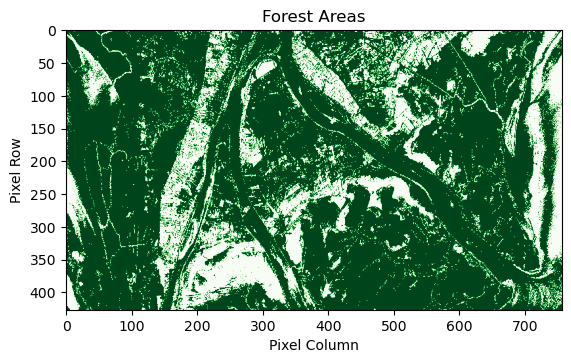

In [15]:
for i in range(forest.shape[0]):
    # Create a plot of the forest areas
    plt.imshow(forest[i], cmap='Greens')  # Green color for forest areas
    # plt.imshow(evi[0], cmap='Reds', alpha=0.3)  # Red color for non-forest areas

    # Add labels and title
    plt.xlabel('Pixel Column')
    plt.ylabel('Pixel Row')
    plt.title('Forest Areas')

    # Show the plot
    plt.show()